<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/071023_Rumor_Model_Hyperedge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd

In [172]:
#!pip install xgi
import xgi

## Part 1: Hypergraph Generation
The following steps generate a hyper graph using the XGI/HyperNetX python package,  following power-law degree distribution for predifined number of nodes n, number of hyperedges num_hyper_edges, degree exponent gamma, using a configuration model with data stored in a dictionary.

In [212]:
# Step 1: Generate Degree Sequence
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    # kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

# Step 2: Generate Hyper Edge Size Sequence
def generate_hyper_edge_sizes(degrees, num_hyper_edges):
    total_degrees = sum(degrees)
    hyper_edge_sizes = []

    # Calculate the average size for each hyper edge
    avg_size = total_degrees // num_hyper_edges
    remainder = total_degrees % num_hyper_edges

    # Define the range for the random distribution
    min_size = 1  # Lower bound of the range
    max_size = len(degrees)-num_hyper_edges  # Upper bound of the range

    # Generate hyper edge sizes
    for _ in range(num_hyper_edges):
        size = random.randint(min_size, max_size)
        hyper_edge_sizes.append(size)

    return hyper_edge_sizes


# Step 3: Create Copies of Nodes
def create_node_copies(degrees):
    node_copies = []
    for i, degree in enumerate(degrees):
        for _ in range(degree):
            node_copies.append(i)
    return node_copies

# Step 4: Create Copies of Hyper Edges
def create_hyper_edge_copies(hyper_edge_sizes):
    hyper_edge_copies = []
    for i, size in enumerate(hyper_edge_sizes):
        for _ in range(size):
            hyper_edge_copies.append(i)
    return hyper_edge_copies

# Step 5: Randomly Pair Copies
def randomly_pair_copies(node_copies, hyper_edge_copies):
    random.shuffle(node_copies)
    random.shuffle(hyper_edge_copies)
    pairs = []
    for i in range(len(node_copies)):
        pairs.append((node_copies[i], hyper_edge_copies[i]))
    return pairs

# Step 6: Convert Bipartite Graph to A Hypergraph Dictionary
def convert_to_hypergraph(pairs):
    hypergraph = {}
    for pair in pairs:
        node, hyper_edge = pair
        if hyper_edge in hypergraph:
            hypergraph[hyper_edge].append(node)
        else:
            hypergraph[hyper_edge] = [node]
    return hypergraph


In [220]:
# Example test usage
n =30  # Number of nodes
gamma = 2.5  # Power-law exponent
kmin = 3  # Minimum degree
num_hyper_edges = 8  # Desired number of hyper edges


# Step 1: Generate Degree Sequence
degrees = generate_degree_sequence(n, gamma, kmin)
print("Degree Sequence: ", degrees)

# Step 2: Generate Hyper Edge Size Sequence
hyper_edge_sizes = generate_hyper_edge_sizes(degrees, num_hyper_edges)
print("Hyper Edge Sizes: ", hyper_edge_sizes)

# Step 3: Create Copies of Nodes
node_copies = create_node_copies(degrees)

# Step 4: Create Copies of Hyper Edges
hyper_edge_copies = create_hyper_edge_copies(hyper_edge_sizes)

# Step 5: Randomly Pair Copies
pairs = randomly_pair_copies(node_copies, hyper_edge_copies)

# Step 6: Convert Bipartite Graph to Hypergraph
hyperedge_dict = convert_to_hypergraph(pairs)

# Print the resulting hypergraph
print("Hypergraph Dictionary: ", hyperedge_dict)


Degree Sequence:  [5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Hyper Edge Sizes:  [16, 19, 9, 5, 12, 21, 16, 20]
Hypergraph Dictionary:  {0: [23, 14, 19, 9, 7, 18, 3, 0, 19, 21, 18, 10, 27, 12, 12], 1: [21, 23, 8, 25, 29, 13, 7, 24, 8, 22, 4, 9, 1, 23], 7: [3, 17, 2, 4, 29, 8, 12, 0, 2, 4, 16, 20, 28, 9, 24, 27, 11], 5: [18, 26, 6, 25, 15, 5, 21, 0, 16, 16, 15, 13, 20], 6: [19, 5, 11, 26, 28, 20, 0, 17, 3, 14, 24], 4: [11, 22, 22, 15, 6, 26, 7, 28, 10, 6, 2], 2: [29, 1, 10, 1, 14, 13, 5, 17], 3: [25, 27, 0]}


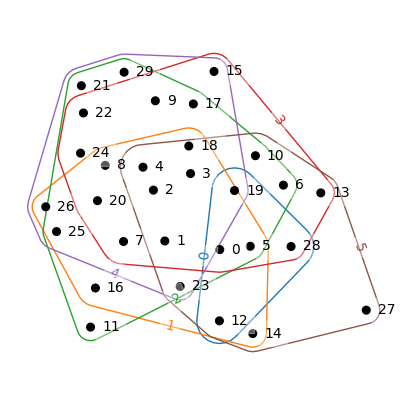

In [211]:
# Plot the hypergraph
import hypernetx as hnx
H = hnx.Hypergraph(hyperedge_dict)
plt.subplots(figsize=(5,5))
hnx.draw(H)

In [221]:
# alternative way to draw the hypergraph
# H2 = xgi.Hypergraph(hyperedge_dict)
# pos = xgi.barycenter_spring_layout(H2)
# xgi.draw(H, pos, node_labels=True, font_color_nodes="gray")

## Part 2: Assign Threshold
The following steps assigns a threshold value to each node in the network. The threshold follows a uniform or normal distribution with predefined mean (mu) and standard deviation (sigma).

In [227]:
import numpy as np
import random

# Defines the parameters to be used
mu = 0.2
sigma = 0.5

# Function to assign thresholds to the individual nodes
def assign_thresholds(hypergraph):
    NV = hypergraph.order()
    Ltre = {}

    for node in hypergraph.nodes():
          # Uniform distribution: #
          Ltre[node] = np.random.uniform(0, 0.1)
          # Normal distrution
          #while True:
          #    threshold = random.gauss(mu, sigma)
          #    if 0 < threshold < 1:
          #        break
          #Ltre[node] = threshold

    return Ltre

Ltre = assign_thresholds(H)

print("Threshold List for Nodes: ", Ltre )

Threshold List for Nodes:  {0: 0.0360569264821187, 1: 0.01264349553965527, 2: 0.07016100939832746, 3: 0.04095866965904247, 4: 0.0021076331876563993, 5: 0.049553957266429194, 6: 0.057800988363673395, 7: 0.0951117315538153, 8: 0.028803486611514818, 9: 0.03964117162854719, 10: 0.019161535292957665, 11: 0.01365300645226767, 12: 0.02019611657816245, 13: 0.04009928112908767, 14: 0.08302746313955398, 15: 0.05432665116902842, 16: 0.017777053984264646, 17: 0.09176881428101873, 18: 0.09821525251194768, 19: 0.02387472859386175, 20: 0.05593089092226419, 21: 0.07978440572395355, 22: 0.09512827971348002, 23: 0.09425254223503703, 24: 0.04149976086564755, 25: 0.02352711112303456, 26: 0.059242270281845845, 27: 0.0792204699624327, 28: 0.027317395352879716, 29: 0.08992409114570377}


## Part 3: Rumor Spreading on Hypergraph
The follow steps extends the basic rumor spreading model to a hypergraph. An infection or recovery event can only happen if its infected or recovered neighbors reach a pre-assigned threshold.  

In [233]:
def Rumor_Hyperedge(nw, ldeg, ltre, lam, alp, n_samp):
    t_max = 100
    N = nw.order()
    kmax = max(ldeg)

    t_end = 0
    stifler_fractions = []

    for i_samp in range(1, n_samp+1):
        t = 0
        N_rec = 0

        states = {j: 0 for j in nw.nodes()}

        inf = []
        rec = []
        initial_node = np.random.choice(list(nw.nodes()))
        states[initial_node] = 1
        inf.append(initial_node)
        N_inf = 1
        N_e = nw.degree(initial_node)

        while N_inf != 0:
            total_rate = lam * N_e + 2 * alp * N_e
            tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
            t += tau

            if t >= t_max:
                break

            # Determine which event occurs
            event = np.random.uniform()
            p1 = lam / (lam + 2 * alp)
            #p2 = (lam + alp )/ (lam + 2 * alp)

            # Determine if accept selected spreader based on degree distribution
            q_deg = np.random.uniform()



            # Infection:
            if event <= p1:
                # Select a spreader individual to spread the rumor
                    inf_node = random.choice(inf)
                    #if q_deg < ldeg[inf_node] / kmax:
                    # Select a random hyper edge containing the infected node
                    infected_hyper_edge = random.choice(list(nw.edges()))
                    while inf_node not in nw.nodes[infected_hyper_edge]:
                          infected_hyper_edge = random.choice(list(nw.edges()))

                    neighbors = nw.nodes[infected_hyper_edge]

                    for neighbor in neighbors:
                        # Check if the selected neighbor is ignorant
                        if states[neighbor] == 0:
                            # Check the threshold
                            count_inf_neighbors = 0
                            for node in nw.neighbors(neighbor):
                                if states[node] == 1:
                                    count_inf_neighbors += 1
                            if count_inf_neighbors / len(nw.neighbors(neighbor)) >= Ltre[neighbor]:
                                states[neighbor] = 1  # ignorant neighbor becomes spreader
                                inf.append(neighbor)
                                N_inf += 1
                                N_e += nw.degree(neighbor)
                                print(inf)

            else: # Recovery
                # Select a spreader individual to recover
                    rec_node = np.random.choice(inf)
                    #if q_deg < ldeg[rec_node]/kmax:
                    # Select a random hyper edge containing the infected node
                    recovered_hyper_edge = random.choice(list(nw.edges()))
                    while rec_node not in nw.nodes[recovered_hyper_edge]:
                          recovered_hyper_edge = random.choice(list(nw.edges()))

                    neighbors = nw.nodes[recovered_hyper_edge]

                    ##if event <= p2:
                    for neighbor in neighbors:
                        # Check the threshold
                            count_rec_neighbors = 0
                            for node in neighbors:
                                if states[node] == 2 or states[node] == 1:
                                    count_rec_neighbors += 1
                            if count_rec_neighbors / len(neighbors) >= Ltre[rec_node]:
                                # Update spreader to stifler if the selected neighbor is a stifler
                                states[rec_node] = 2
                                N_inf -= 1
                                N_e -= nw.degree(rec_node)
                                inf.remove(rec_node)
                                rec.append(rec_node)
                                N_rec += 1
                                print(rec)

                    """
                    else:
                        for neighbor in neighbors:
                        # Check the threshold of infected
                            count_inf_neighbors = 0
                            for node in neighbors:
                                if states[node] == 1:
                                    count_inf_neighbors += 1
                            if count_inf_neighbors / len(neighbors) >= Ltre[rec_node]:
                                # Update spreader to stifler if the selected neighbor is a stifler
                                states[rec_node] = 2
                                N_inf -= 1
                                N_e -= nw.degree(rec_node)
                                inf.remove(rec_node)
                                rec.append(rec_node)
                                N_rec += 1
                    """

        if N_inf == 0:
              t_end += t
              stifler_frac = N_rec / N
              stifler_fractions.append(stifler_frac)
              print(lam, N_rec, t_end, stifler_frac)

    #avg_stifler_frac = sum(stifler_fractions) / len(stifler_fractions)
    #t_end_av = t_end/n_samp

    return nw, states

In [ ]:
H, states = Rumor_Hyperedge(H, degrees, Ltre, 0.5, 1, 1)

In [224]:
def plot_hypergraph(hypergraph, states, thresholds):
    pos = nx.spring_layout(hypergraph)
    node_colors = []
    node_sizes = []
    for node in hypergraph.nodes():
        if states[node] == 1:  # Infected node (purple)
            node_colors.append("purple")
        elif states[node] == 2:  # Recovered node (green)
            node_colors.append("green")
        else:  # Susceptible node (yellow)
            node_colors.append("yellow")
        node_sizes.append(thresholds[node] * 100)  # Adjust node size based on threshold value

    hnx.drawing.draw(hypergraph, pos, nodes_kwargs={'facecolors': node_colors})

In [ ]:
#plot_hypergraph(H, states, Ltre)